In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml
import sys

from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

In [3]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

In [4]:
twitter_datapath = AbsolutePathBuilder.get_path(
    "04_twitter_scored",
    filepaths="../../../../config/filepaths.yaml"
)

In [5]:
filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(twitter_datapath, "*"))]

data = []
for filename in filenames:
    description = {}
    
    description["filename"] = filename
    description["group"] = filename.split("_")[0]
    
    data.append(description)
    
df_data_desc = pd.DataFrame(data)

df_data_desc["group"] = (
    df_data_desc
    .group.apply(
        lambda group: "Black"
        if group=='aa'
        else "White"
    )
)

---

### Toxicity Score Cumulative Distribution Function (CDF)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.91it/s]


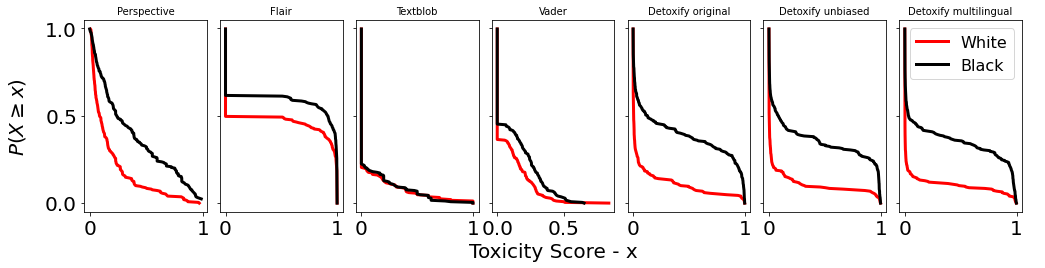

In [6]:
group_color = {
    "White": "red",
    "Black": "black",
}

fig, axs = plt.subplots(1, 7, figsize=(15, 4), sharey=True)

for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "perspective",
            "flair",
            "textblob",
            "vader",
            "detoxify_original",
            "detoxify_unbiased",
            "detoxify_multilingual"
        ]
    )
):
    for group in group_color.keys():
        df_group = df_data_desc[df_data_desc.group == group]

        dfs = []
        count = 0
        for filename in df_group.filename.values:
            try:
                df = pd.read_csv(os.path.join(twitter_datapath, filename))
                dfs.append(df)
            except:
                count += 1

        df = pd.concat(dfs)
        del dfs

        ecdf = ECDF(df[f"{SCORE_NAME}_score"])
        axs[i].plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
        
    axs[i].set_title(f"{SCORE_NAME.replace('_', ' ').capitalize()}", fontsize=10)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Toxicity Score - x")
plt.ylabel(r"$P(X \geq x)$")
plt.tight_layout(pad=0)
plt.savefig(
    os.path.join(
        AbsolutePathBuilder.get_path(
            "twitter_imgs",
            filepaths="../../../../config/filepaths.yaml"
        ),
        f"twitter_icdfs.pdf"
    )
)
plt.show()

---

### Toxicity Score Distribution

Group: `Black` had 250 reading problems


ValueError: No objects to concatenate

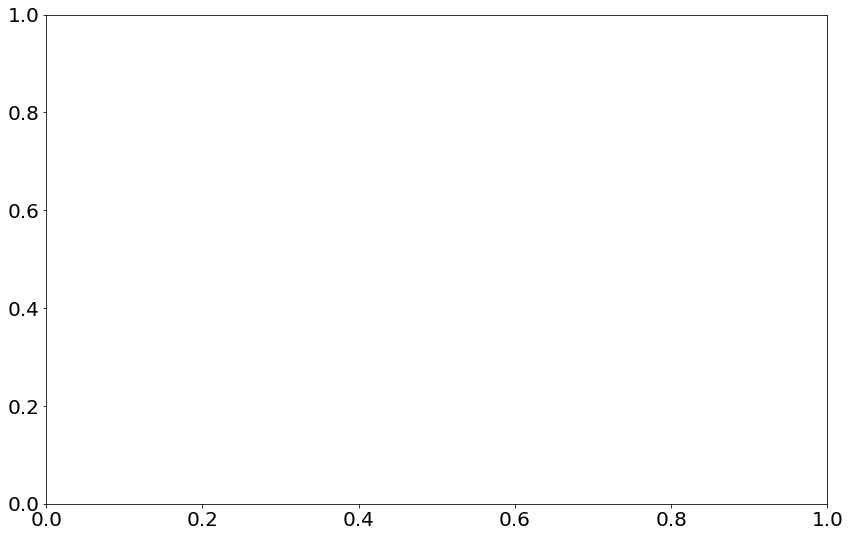

In [6]:
plt.subplots(figsize=(14,9))

dfs = []
for group in df_data_desc["group"].unique():
    df_group = []
    count = 0
    for filename in df_data_desc.loc[df_data_desc.group == group, "filename"].values:
        try:
            df = pd.read_csv(os.path.join(filepaths["04_twitter_scored"], filename))
            
            df = df[~df.has_swearing]
            df_group.append(df)
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df_group = pd.concat(df_group)
    df_group["group"] = group
    
    dfs.append(df_group)

df = pd.concat(dfs)
del dfs, df_group

sns.boxplot(data=df, x="group", y=score_name, showfliers=False)
plt.xlabel("Group")
plt.ylabel("Score")

plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [ ]:
ks_all = []
groups = df.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            df[df.group == first_group][score_name],
            df[df.group == second_group][score_name]
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

In [ ]:
pd.DataFrame(ks_all, columns=groups, index=groups)